## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

### l1 ratio

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0811 12:01:06.506652  2316 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0811 12:01:06.507625  2316 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 12:01:06.565470  2316 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 12:01:06.565470  2316 deprecation_wrapper.py:119] From C:\Users\an_fl\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 12:01:06.569461  2316 

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0811 12:01:06.768619  2316 deprecation.py:323] From C:\Users\an_fl\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 136us/step - loss: 198.6741 - acc: 0.2327 - val_loss: 41.1030 - val_acc: 0.2642
Epoch 2/20
50000/50000 [==============================] - 6s 124us/step - loss: 19.0999 - acc: 0.1211 - val_loss: 7.2905 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 6s 122us/step - loss: 4.1110 - acc: 0.0968 - val_loss: 2.6461 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 6s 123us/step - loss: 2.4862 - acc: 0.1001 - val_loss: 2.4625 - val_acc: 0.1000c:
Epoch 5/20
50000/50000 [==============================] - 6s 122us/step - loss: 2.4626 - acc: 0.0991 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 6s 123us/step - loss: 2.4626 - acc: 0.0998 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 6s 124us/step - loss: 2.4626 - acc: 0.0967 - val_loss: 2.4

50000/50000 [==============================] - 7s 139us/step - loss: 1.6735 - acc: 0.4125 - val_loss: 1.6484 - val_acc: 0.4214
Epoch 5/20
50000/50000 [==============================] - 7s 139us/step - loss: 1.6264 - acc: 0.4294 - val_loss: 1.6159 - val_acc: 0.4342
Epoch 6/20
50000/50000 [==============================] - 7s 139us/step - loss: 1.5864 - acc: 0.4446 - val_loss: 1.5764 - val_acc: 0.4450
Epoch 7/20
50000/50000 [==============================] - 7s 140us/step - loss: 1.5533 - acc: 0.4553 - val_loss: 1.5503 - val_acc: 0.4590
Epoch 8/20
50000/50000 [==============================] - 7s 140us/step - loss: 1.5225 - acc: 0.4648 - val_loss: 1.5256 - val_acc: 0.4615
Epoch 9/20
50000/50000 [==============================] - 7s 141us/step - loss: 1.4939 - acc: 0.4760 - val_loss: 1.5105 - val_acc: 0.4669
Epoch 10/20
50000/50000 [==============================] - 7s 141us/step - loss: 1.4680 - acc: 0.4840 - val_loss: 1.4918 - val_acc: 0.4694
Epoch 11/20
50000/50000 [===================

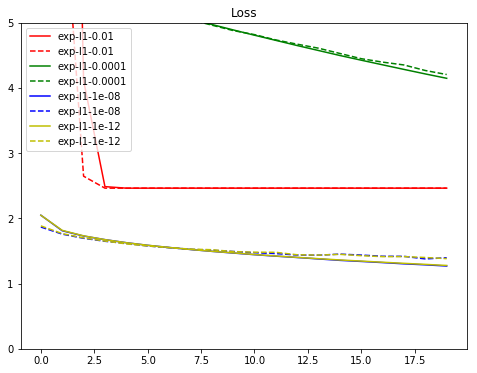

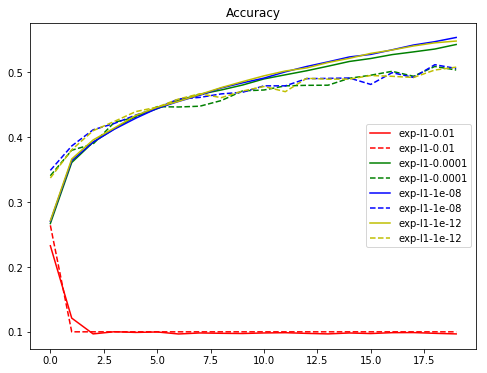

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### l2 ratio

In [9]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 151us/step - loss: 2.0418 - acc: 0.2642 - val_loss: 1.8804 - val_acc: 0.3354
Epoch 2/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.8162 - acc: 0.3623 - val_loss: 1.7666 - val_acc: 0.3830
Epoch 3/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.7291 - acc: 0.3931 - val_loss: 1.6946 - val_acc: 0.3997
Epoch 4/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.6685 - acc: 0.4147 - val_loss: 1.6474 - val_acc: 0.4185
Epoch 5/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.6217 - acc: 0.4319 - val_loss: 1.6177 - val_acc: 0.4278
Epoch 6/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.5837 - acc: 0.4444 - val_loss: 1.5638 - val_acc: 0.4454
Epoch 7/20
50000/50000 [==============================] - 7s 145us/step - loss: 1.5482 - acc: 0.4572 - val_loss: 1.5536 - 

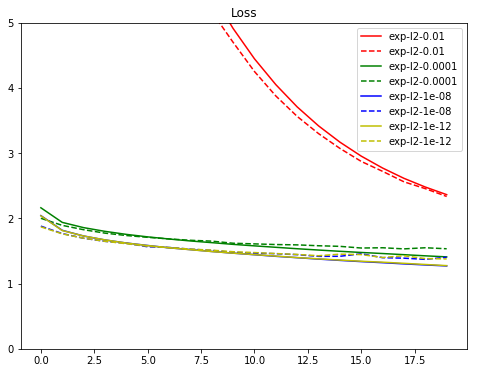

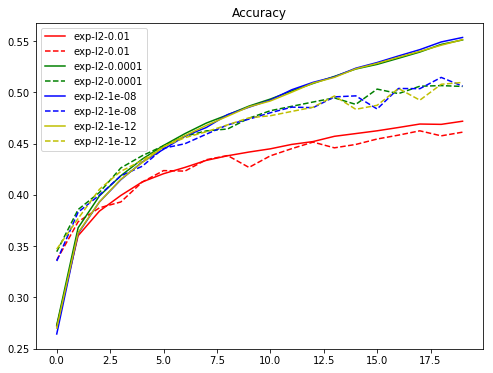

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### l1_l2 ratio

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4]
L2_EXP = [1e-2, 1e-4]

In [13]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio_l1 in L1_EXP:
    for regulizer_ratio_l2 in L2_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer_L1 = %.6f, Regulizer_L2 = %.6f" % (regulizer_ratio_l1, regulizer_ratio_l2))
        model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio_l1, l2_ratio=regulizer_ratio_l2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l1-%s, exp-l2-%s" % (str(regulizer_ratio_l1), str(regulizer_ratio_l2))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with Regulizer_L1 = 0.010000, Regulizer_L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 139us/step - loss: 15.8104 - acc: 0.2733 - val_loss: 14.6231 - val_acc: 0.3365
Epoch 2/20
50000/50000 [==============================] - 7s 132us/step - loss: 13.6336 - acc: 0.3570 - val_loss: 12.6922 - val_acc: 0.3658
Epoch 3/20
50000/50000 [==============================] - 7s 135us/step - loss: 11.8682 - acc: 0.3809 - val_loss: 11.0718 - val_acc: 0.3927
Epoch 4/20
50000/50000 [==============================] - 7s 135us/step - loss: 10.3777 - acc: 0.3942 - val_loss: 9.7022 - val_acc: 0.3984
Epoch 5/20
50000/50000 [==============================] - 7s 134us/step - loss: 9.1103 - acc: 0.4066 - val_loss: 8.5343 - val_acc: 0.4031
Epoch 6/20
50000/50000 [==============================] - 7s 133us/step - loss: 8.0321 - acc: 0.4125 - val_loss: 7.5440 - val_acc: 0.4105
Epoch 7/20
50000/50000 [==============================] - 7s 134us/step - loss: 7.1107 - acc: 0.4179 - val_loss: 6.

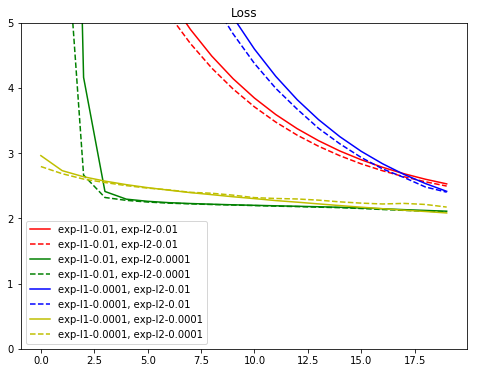

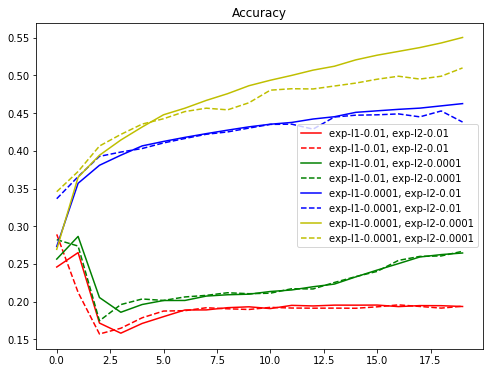

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()